https://drive.google.com/file/d/1EE0XHDJZnzXSNPOM1GknhxasiQBIrzSD/view?usp=sharing

#Estate Price Prediction in Melbourne

In [172]:
! gdown 1EE0XHDJZnzXSNPOM1GknhxasiQBIrzSD

Downloading...
From: https://drive.google.com/uc?id=1EE0XHDJZnzXSNPOM1GknhxasiQBIrzSD
To: /content/leopard-challenge-regression.zip
100% 1.00M/1.00M [00:00<00:00, 184MB/s]


In [173]:
! unzip -o /content/leopard-challenge-regression.zip -d /content/leopard-challenge

Archive:  /content/leopard-challenge-regression.zip
  inflating: /content/leopard-challenge/sample_submission.csv  
  inflating: /content/leopard-challenge/test.csv  
  inflating: /content/leopard-challenge/train.csv  


##Install

In [174]:
! pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [175]:
! pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [176]:
! pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [177]:
#!pip install phik -q

##Import

In [178]:
import pandas as pd

import seaborn as sns

import matplotlib.pyplot as plt
import missingno as msno

import phik

import folium

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

from catboost import CatBoostRegressor, Pool, cv

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

import joblib

import shap
#shap.initjs()

In [179]:
df = pd.read_csv('/content/leopard-challenge/train.csv')

In [180]:
df.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,id
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,2.0,1.0,1.0,202.0,NaN,NaN,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,4019.0,34302
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,1900.0,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4019.0,33247
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,0.0,134.0,150.0,1900.0,Yarra City Council,-37.8093,144.9944,Northern Metropolitan,4019.0,31886
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,1.0,94.0,NaN,NaN,Yarra City Council,-37.7969,144.9969,Northern Metropolitan,4019.0,18999
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,3.0,1.0,2.0,120.0,142.0,2014.0,Yarra City Council,-37.8072,144.9941,Northern Metropolitan,4019.0,16809


In [181]:
test_kaggle = pd.read_csv('/content/leopard-challenge/test.csv')

In [182]:
test_kaggle.head()

,Suburb,Address,Rooms,Type,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,id
0,Abbotsford,513/6 Acacia Pl,3,u,S,Dingle,7/10/2017,3.0,3067.0,NaN,NaN,NaN,NaN,NaN,NaN,Yarra City Council,NaN,NaN,Northern Metropolitan,4019.0,30130
1,Abbotsford,60 Charles St,3,h,S,Jellis,7/10/2017,3.0,3067.0,3.0,1.0,NaN,192.0,109.0,1900.0,Yarra City Council,-37.80792,144.99508,Northern Metropolitan,4019.0,18311
2,Abbotsford,38 Studley St,3,h,S,Nelson,7/10/2017,3.0,3067.0,3.0,1.0,1.0,159.0,93.0,1890.0,Yarra City Council,-37.80124,144.99459,Northern Metropolitan,4019.0,18934
3,Airport West,18 Glenys Av,3,h,S,Raine,7/10/2017,10.4,3042.0,3.0,1.0,5.0,536.0,108.0,1980.0,Moonee Valley City Council,-37.72285,144.87539,Western Metropolitan,3464.0,1824
4,Airport West,35 Thomas St,3,h,S,Nelson,7/10/2017,10.4,3042.0,3.0,1.0,1.0,NaN,130.0,2009.0,Moonee Valley City Council,-37.71754,144.87704,Western Metropolitan,3464.0,31339


In [183]:
pd.options.display.max_columns = 100 

In [184]:
df.columns

Index(['Suburb', 'Address', 'Rooms', 'Type', 'Price', 'Method', 'SellerG',
       'Date', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car',
       'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea', 'Lattitude',
       'Longtitude', 'Regionname', 'Propertycount', 'id'],
      dtype='object')

In [185]:
test_kaggle.columns

Index(['Suburb', 'Address', 'Rooms', 'Type', 'Method', 'SellerG', 'Date',
       'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car', 'Landsize',
       'BuildingArea', 'YearBuilt', 'CouncilArea', 'Lattitude', 'Longtitude',
       'Regionname', 'Propertycount', 'id'],
      dtype='object')

In [186]:
len(df)

18373

In [187]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18373 entries, 0 to 18372
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         18373 non-null  object 
 1   Address        18373 non-null  object 
 2   Rooms          18373 non-null  int64  
 3   Type           18373 non-null  object 
 4   Price          18373 non-null  float64
 5   Method         18373 non-null  object 
 6   SellerG        18373 non-null  object 
 7   Date           18373 non-null  object 
 8   Distance       18373 non-null  float64
 9   Postcode       18373 non-null  float64
 10  Bedroom2       14905 non-null  float64
 11  Bathroom       14903 non-null  float64
 12  Car            14798 non-null  float64
 13  Landsize       13579 non-null  float64
 14  BuildingArea   7750 non-null   float64
 15  YearBuilt      8944 non-null   float64
 16  CouncilArea    18372 non-null  object 
 17  Lattitude      15041 non-null  float64
 18  Longti

##EDA

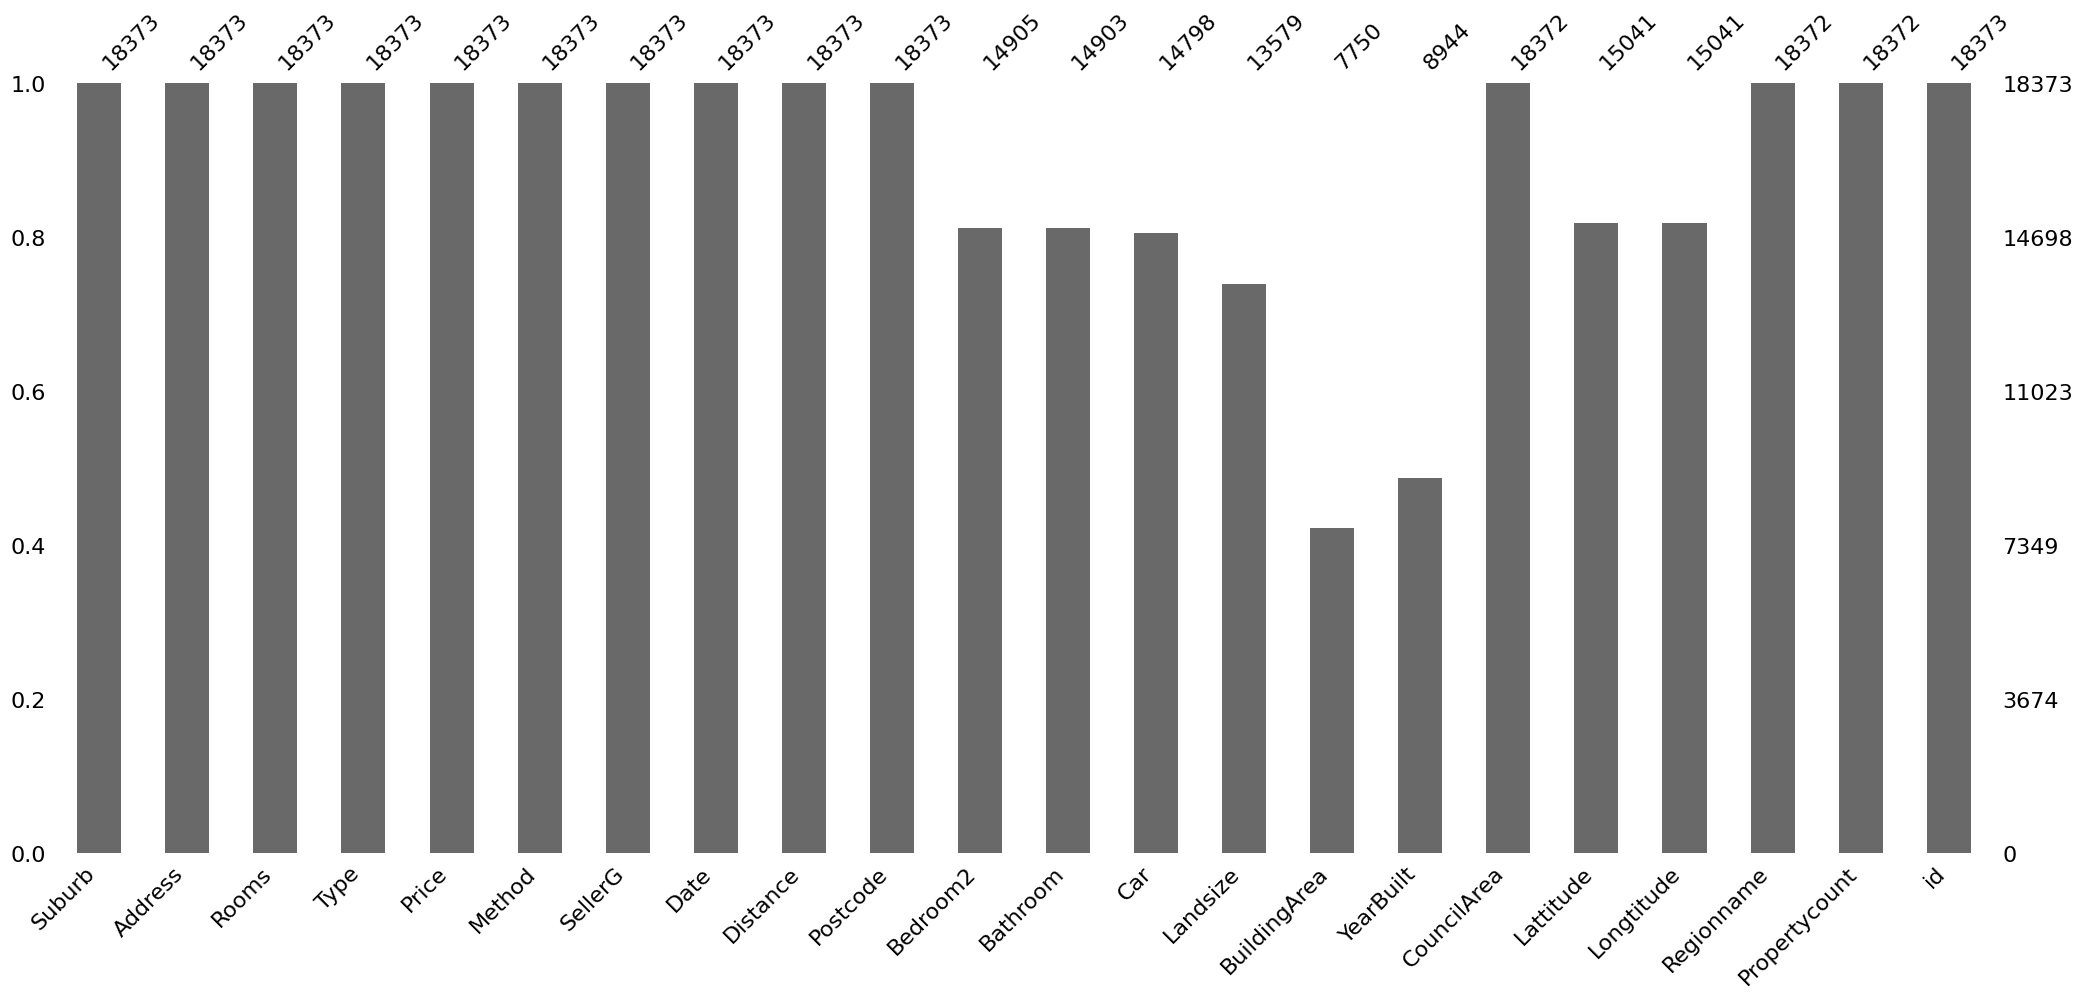

In [188]:
msno.bar(df);

In [189]:
df.isna().mean()

Suburb           0.000000
Address          0.000000
Rooms            0.000000
Type             0.000000
Price            0.000000
Method           0.000000
SellerG          0.000000
Date             0.000000
Distance         0.000000
Postcode         0.000000
Bedroom2         0.188755
Bathroom         0.188864
Car              0.194579
Landsize         0.260926
BuildingArea     0.578185
YearBuilt        0.513199
CouncilArea      0.000054
Lattitude        0.181353
Longtitude       0.181353
Regionname       0.000054
Propertycount    0.000054
id               0.000000
dtype: float64

In [190]:
df.duplicated().sum()

0

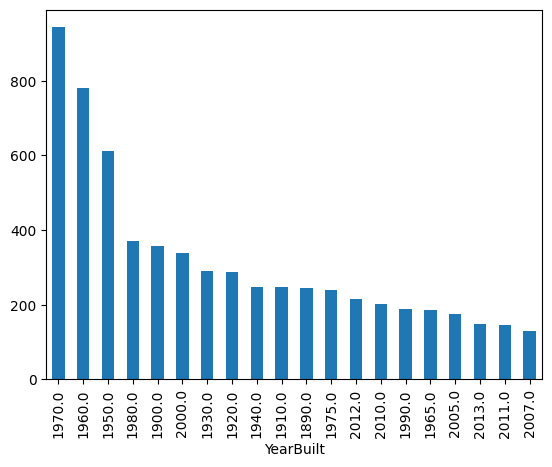

In [191]:
df.groupby('YearBuilt')['id'].nunique().sort_values(ascending=False).head(20).plot(kind='bar');

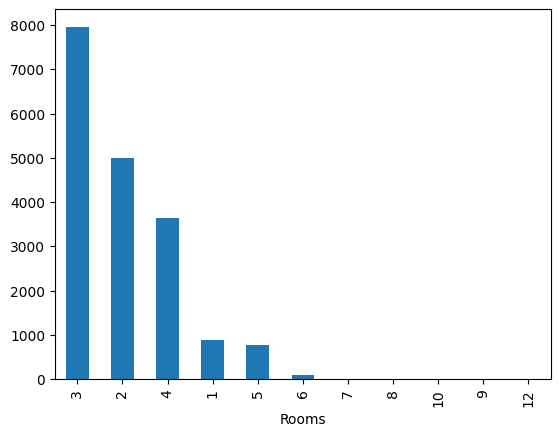

In [192]:
df.groupby('Rooms')['id'].nunique().sort_values(ascending=False).head(20).plot(kind='bar');

In [193]:
df['Date'].min()

'1/07/2017'

In [194]:
df['Date'].max()

'9/09/2017'

In [195]:
df['Type'].value_counts()

h    12091
u     4275
t     2007
Name: Type, dtype: int64

In [196]:
df[['Price','Rooms',	'Distance',	'Bedroom2', 'Bathroom',	'Car',	'BuildingArea',	'YearBuilt']].describe()

,Price,Rooms,Distance,Bedroom2,Bathroom,Car,BuildingArea,YearBuilt
count,1.837300e+04,18373.000000,18373.000000,14905.000000,14903.000000,14798.000000,7750.000000,8944.000000
mean,1.053235e+06,2.936592,10.403962,2.914928,1.538683,1.617313,151.133167,1965.925089
std,6.217973e+05,0.955952,6.018424,0.962743,0.688374,0.957072,519.517626,36.958956
min,2.270000e+05,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1196.000000
25%,6.350000e+05,2.000000,6.300000,2.000000,1.000000,1.000000,93.000000,1950.000000
50%,8.800000e+05,3.000000,9.700000,3.000000,1.000000,2.000000,126.000000,1970.000000
75%,1.301000e+06,3.000000,13.300000,3.000000,2.000000,2.000000,173.862500,2000.000000
max,5.580000e+06,12.000000,48.100000,20.000000,8.000000,10.000000,44515.000000,2018.000000


In [197]:
#df[['Price','Rooms',	'Distance',	'Bedroom2', 'Bathroom',	'Car',	'BuildingArea',	'YearBuilt']]\
#.describe().style.background_gradient(cmap = "coolwarm")

In [198]:
df.describe(include = "object").T

,count,unique,top,freq
Suburb,18373,329,Reservoir,540
Address,18373,18112,28 Blair St,3
Type,18373,3,h,12091
Method,18373,5,S,12025
SellerG,18373,305,Nelson,2001
Date,18373,59,27/05/2017,610
CouncilArea,18372,33,Boroondara City Council,1896
Regionname,18372,8,Southern Metropolitan,6326


In [199]:
df['CouncilArea'] = df['CouncilArea'].fillna('no_info')
df['Regionname'] = df['Regionname'].fillna('no_info')

In [200]:
df.isna().mean()

Suburb           0.000000
Address          0.000000
Rooms            0.000000
Type             0.000000
Price            0.000000
Method           0.000000
SellerG          0.000000
Date             0.000000
Distance         0.000000
Postcode         0.000000
Bedroom2         0.188755
Bathroom         0.188864
Car              0.194579
Landsize         0.260926
BuildingArea     0.578185
YearBuilt        0.513199
CouncilArea      0.000000
Lattitude        0.181353
Longtitude       0.181353
Regionname       0.000000
Propertycount    0.000054
id               0.000000
dtype: float64

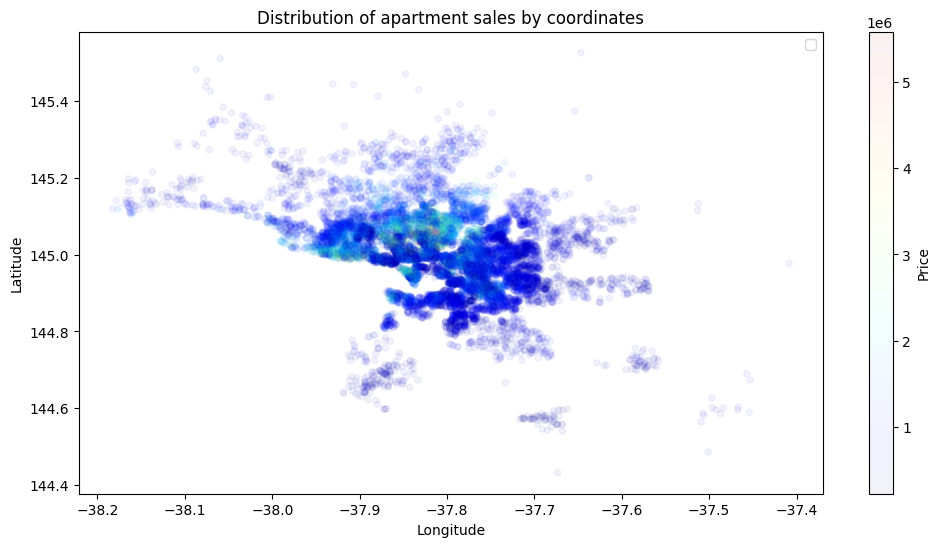

In [201]:
df.plot(kind='scatter', x='Lattitude', y='Longtitude', alpha=0.05, figsize=(12,6),
       c='Price', cmap=plt.get_cmap('jet'), colorbar=True)
plt.legend()
plt.title('Distribution of apartment sales by coordinates')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [202]:
#def color_change(price):
 #   if (227000 <= price < 635000):
  #      return('green')
   # elif(635000 <= price < 880000):
    #    return('orange')
    #elif(880000 <= price < 1301000):
    #    return('blue')
   # else:
   #     return('red')
   # 
#map = folium.Map(location=[-38.00,144.63000], zoom_start = 10)
#lat = df['Lattitude'].dropna()
#lon = df['Longtitude'].dropna()
#price = df['Price'].dropna()

#for lat, lon, price in zip(lat, lon, price):
#    folium.CircleMarker(location=[lat, lon], radius = 2, popup=str(price)+"m", 
#                        fill_color=color_change(price), color=color_change(price), fill_opacity = 0.9).add_to(map)
    
#map

##Baseline

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


<Axes: >

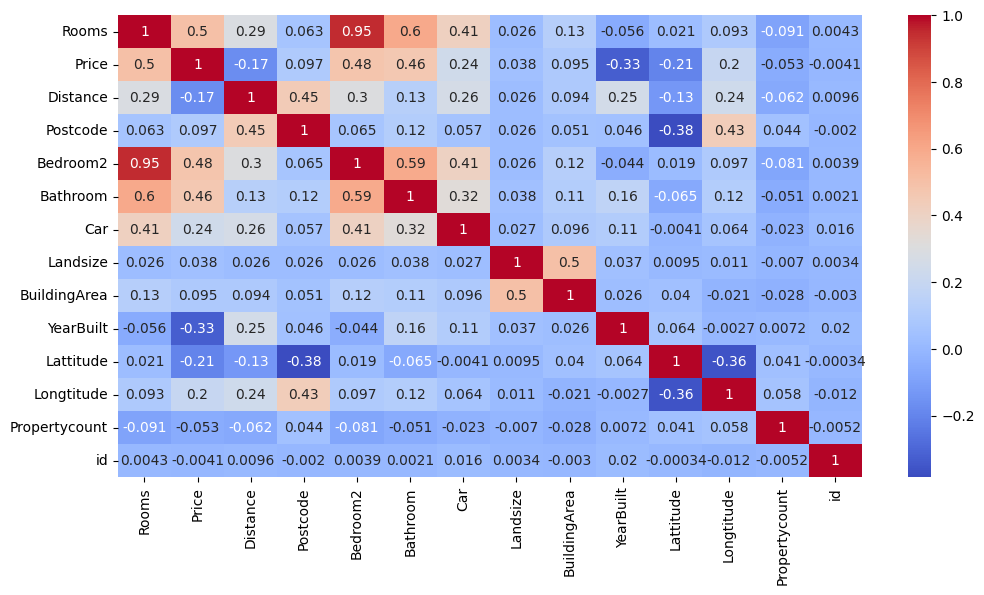

In [203]:
plt.figure(figsize=(12,6))
sns.heatmap(df.corr(),annot=True,cmap="coolwarm")

In [204]:
#phik_overview = df.phik_matrix()
#phik_overview['Price'].round(2).sort_values(ascending=False)

In [205]:
df.columns

Index(['Suburb', 'Address', 'Rooms', 'Type', 'Price', 'Method', 'SellerG',
       'Date', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car',
       'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea', 'Lattitude',
       'Longtitude', 'Regionname', 'Propertycount', 'id'],
      dtype='object')

In [206]:
base = df.groupby(['Suburb', 'Rooms', 'Type'])['Price'].mean().reset_index()

In [207]:
base

,Suburb,Rooms,Type,Price
0,Abbotsford,1,u,4.393500e+05
1,Abbotsford,2,h,1.108318e+06
2,Abbotsford,2,t,7.960000e+05
3,Abbotsford,2,u,6.700000e+05
4,Abbotsford,3,h,1.275580e+06
...,...,...,...,...
2006,Yarraville,4,h,1.249776e+06
2007,Yarraville,4,t,9.300000e+05
2008,Yarraville,5,h,1.324875e+06
2009,Yarraville,6,h,2.450000e+06


In [208]:
base = base.rename({'Price':'baseline'},axis=1)

In [209]:
df = df.merge(base,how='left',on=['Suburb', 'Rooms', 'Type'])

In [210]:
df['Price'].mean()

1053234.8822184727

In [211]:
(df['Price'] - df['baseline']).mean()

1.6220716479450995e-12

In [212]:
len(df)

18373

In [213]:
len(df['baseline'])

18373

##Training and test set

In [214]:
train, test = train_test_split(df,train_size=0.6,random_state=42)

##Catboost start

In [215]:
train.dtypes

Suburb            object
Address           object
Rooms              int64
Type              object
Price            float64
Method            object
SellerG           object
Date              object
Distance         float64
Postcode         float64
Bedroom2         float64
Bathroom         float64
Car              float64
Landsize         float64
BuildingArea     float64
YearBuilt        float64
CouncilArea       object
Lattitude        float64
Longtitude       float64
Regionname        object
Propertycount    float64
id                 int64
baseline         float64
dtype: object

In [216]:
train.columns

Index(['Suburb', 'Address', 'Rooms', 'Type', 'Price', 'Method', 'SellerG',
       'Date', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car',
       'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea', 'Lattitude',
       'Longtitude', 'Regionname', 'Propertycount', 'id', 'baseline'],
      dtype='object')

In [217]:
train.select_dtypes(include='object').columns

Index(['Suburb', 'Address', 'Type', 'Method', 'SellerG', 'Date', 'CouncilArea',
       'Regionname'],
      dtype='object')

In [218]:
X = ['Rooms', 'Distance', 'Bedroom2', 'Bathroom', 'Car',
       'Landsize', 'BuildingArea', 'YearBuilt', 'Date', 'Lattitude',
       'Longtitude', 'Propertycount', 'id', 'Suburb',
     	'Address',	'Type',	'Method', 'CouncilArea',	'Regionname']

cat_features = ['Suburb',	'Address',	'Date', 'Type',	'Method', 'CouncilArea',	'Regionname']

y = ['Price']

In [219]:
train_full_data = Pool(train[X],
                       label=train[y],
                       cat_features=cat_features)

##First way. CV

In [220]:
parameters = {'cat_features': cat_features,
              'loss_function': 'MAE', 
              'eval_metric': 'MAPE',
              'learning_rate': 0.1,  
              'random_seed':42,
              'verbose':100}

In [221]:
cv_data = cv(
    params = parameters,
    pool = train_full_data, 
    fold_count=5, 
    shuffle=True, 
    partition_random_seed=0, 
    stratified=False, 
    verbose=False 
)

Training on fold [0/5]

bestTest = 0.1512346797
bestIteration = 815

Training on fold [1/5]

bestTest = 0.1503259718
bestIteration = 766

Training on fold [2/5]

bestTest = 0.147433082
bestIteration = 990

Training on fold [3/5]

bestTest = 0.1514424281
bestIteration = 654

Training on fold [4/5]

bestTest = 0.1485856777
bestIteration = 995



In [222]:
cv_data

,iterations,test-MAPE-mean,test-MAPE-std,train-MAPE-mean,train-MAPE-std,test-MAE-mean,test-MAE-std,train-MAE-mean,train-MAE-std
0,0,0.893657,0.000867,0.893571,0.000279,961692.565256,9765.897076,961555.361049,2178.236950
1,1,0.797380,0.001668,0.796615,0.000792,877697.449977,9036.291191,877169.420103,2948.000437
2,2,0.710299,0.002001,0.709849,0.001791,804084.216349,6911.697361,804203.036538,6450.628669
3,3,0.633310,0.003020,0.632936,0.002920,738205.748882,7271.069194,738310.655346,4949.044343
4,4,0.563739,0.003464,0.562426,0.003464,677050.935085,6711.614215,676503.515122,4723.393666
...,...,...,...,...,...,...,...,...,...
995,995,0.149938,0.001846,0.107813,0.000841,167192.024150,4011.301183,124935.465848,1648.459327
996,996,0.149943,0.001836,0.107799,0.000839,167190.674418,4003.300651,124914.635526,1647.898608
997,997,0.149945,0.001831,0.107788,0.000836,167191.393849,4004.094559,124904.458184,1642.585560
998,998,0.149943,0.001836,0.107754,0.000832,167191.937431,4003.716687,124871.972197,1633.470391


In [223]:
cv_data[cv_data['test-MAPE-mean'] == cv_data['test-MAPE-mean'].min()]

,iterations,test-MAPE-mean,test-MAPE-std,train-MAPE-mean,train-MAPE-std,test-MAE-mean,test-MAE-std,train-MAE-mean,train-MAE-std
992,992,0.149936,0.001844,0.107862,0.000845,167212.495468,3997.489087,125003.029901,1651.037404


In [224]:
n_iters = n_iters = cv_data[cv_data['test-MAPE-mean'] == cv_data['test-MAPE-mean'].min()]['iterations'].values[0]

In [225]:
n_iters

992

In [226]:
parameters = {'iterations':n_iters,
              'cat_features': cat_features,
              'loss_function': 'MAE', 
              'eval_metric': 'MAPE',
              'learning_rate': 0.12,  
              'random_seed':42,
              'verbose':100}

In [227]:
model = CatBoostRegressor(**parameters)

In [228]:
model.fit(train[X],train[y])     

0:	learn: 0.3939649	total: 16.5ms	remaining: 16.4s
100:	learn: 0.1527181	total: 1.98s	remaining: 17.5s
200:	learn: 0.1381143	total: 4.96s	remaining: 19.5s
300:	learn: 0.1305710	total: 7.12s	remaining: 16.4s
400:	learn: 0.1249619	total: 8.63s	remaining: 12.7s
500:	learn: 0.1209773	total: 10.2s	remaining: 9.96s
600:	learn: 0.1176663	total: 11.6s	remaining: 7.58s
700:	learn: 0.1148894	total: 13.1s	remaining: 5.43s
800:	learn: 0.1125835	total: 14.6s	remaining: 3.47s
900:	learn: 0.1105573	total: 16s	remaining: 1.62s
991:	learn: 0.1086986	total: 18.7s	remaining: 0us


In [229]:
test['price_pred_all_features'] = model.predict(test[X]) 

In [230]:
test

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,id,baseline,price_pred_all_features
14655,Aspendale Gardens,12 Pacific Dr,4,h,840000.0,VB,Barry,22/07/2017,21.5,3195.0,4.0,2.0,2.0,383.0,NaN,NaN,Kingston City Council,-38.01958,145.12356,South-Eastern Metropolitan,2243.0,23912,8.350000e+05,8.133721e+05
17371,Carnegie,52 Tranmere Av,4,h,1966000.0,VB,Ray,23/09/2017,10.1,3163.0,4.0,2.0,2.0,627.0,181.0,1905.0,Glen Eira City Council,-37.89184,145.06056,Southern Metropolitan,7822.0,29446,1.573053e+06,1.857262e+06
2874,Eaglemont,20 Glenard Dr,4,h,2309000.0,S,Nelson,28/08/2016,10.3,3084.0,4.0,3.0,2.0,1177.0,291.0,1960.0,Banyule City Council,-37.76520,145.06870,Eastern Metropolitan,1651.0,6870,2.177500e+06,2.176632e+06
14844,Mount Waverley,4 William St,4,h,1750000.0,SP,Jellis,22/07/2017,14.2,3149.0,4.0,2.0,2.0,766.0,NaN,NaN,Monash City Council,-37.88043,145.13062,Eastern Metropolitan,13366.0,13611,1.471360e+06,1.394570e+06
8866,Hawthorn East,218/12 Albert St,1,u,375000.0,PI,hockingstuart,22/05/2016,7.5,3123.0,NaN,NaN,NaN,NaN,NaN,NaN,Boroondara City Council,NaN,NaN,Southern Metropolitan,6482.0,9080,4.165909e+05,4.133537e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14217,South Yarra,2/1 Alexandra Av,2,u,1350000.0,S,Kay,12/08/2017,2.7,3141.0,2.0,2.0,1.0,0.0,109.0,1930.0,Melbourne City Council,-37.82863,144.98514,Southern Metropolitan,14887.0,3546,7.437577e+05,9.749344e+05
3954,Hampton East,9/12 Bartlett St,2,u,400000.0,S,Greg,4/03/2017,14.5,3188.0,2.0,1.0,1.0,0.0,75.0,1960.0,Bayside City Council,-37.93670,145.03220,Southern Metropolitan,2356.0,26650,6.609545e+05,5.976574e+05
4403,Keilor East,1/36 Phillip Rd,2,h,380000.0,S,Nelson,14/05/2016,12.8,3033.0,2.0,1.0,1.0,116.0,NaN,NaN,Brimbank City Council,-37.74800,144.86960,Western Metropolitan,5629.0,19628,3.800000e+05,4.846111e+05
16939,Craigieburn,21 Huntingfield St,2,t,358000.0,S,Ray,19/08/2017,20.6,3064.0,2.0,1.0,2.0,NaN,NaN,2012.0,Hume City Council,-37.58403,144.90791,Northern Metropolitan,15510.0,27681,3.470000e+05,4.163559e+05


##Aecond way. Optuna

In [231]:
def objective(trial):
    global train_full_data

    param = {
        #'task_type':trial.suggest_categorical("task_type", 'CPU'),
        #'devices':trial.suggest_int('devices', 0, 1),
        "n_estimators": trial.suggest_int("n_estimators", 1000, 4000, 200),
        "max_depth": trial.suggest_int("max_depth", 2, 10, 1),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 8),
        "random_strength": trial.suggest_float("random_strength", 0.9, 1.4),
        "learning_rate": trial.suggest_float("eta", 1e-2, 1e-1, log=True),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 3, 5),
        "grow_policy": trial.suggest_categorical("grow_policy", ["Lossguide"]),
        #"boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "eval_metric": trial.suggest_categorical("eval_metric", ["MAPE"]),
        "loss_function": trial.suggest_categorical("loss_function", ["MAE"]),
        "silent": trial.suggest_categorical("silent", [True]),
        #'logging_level': trial.suggest_categorical('logging_level', ['Silent']),
    }

    scores = cv(
    params = param,
    pool = train_full_data, 
    fold_count=5, 
    shuffle=True, 
    partition_random_seed=0, 
    stratified=False, 
    verbose=False 
)

    return scores['test-MAPE-mean'].values[-1]

In [232]:
%%time
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5, show_progress_bar = True)

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/5 [00:00<?, ?it/s]

Training on fold [0/5]

bestTest = 0.1574080209
bestIteration = 1591

Training on fold [1/5]

bestTest = 0.1555958848
bestIteration = 1598

Training on fold [2/5]

bestTest = 0.1562413207
bestIteration = 1599

Training on fold [3/5]

bestTest = 0.1581419347
bestIteration = 1599

Training on fold [4/5]

bestTest = 0.1536800187
bestIteration = 1547

Training on fold [0/5]

bestTest = 0.152095695
bestIteration = 1197

Training on fold [1/5]

bestTest = 0.1495130417
bestIteration = 1199

Training on fold [2/5]

bestTest = 0.1510247423
bestIteration = 1199

Training on fold [3/5]

bestTest = 0.15341959
bestIteration = 1188

Training on fold [4/5]

bestTest = 0.1496923555
bestIteration = 1198

Training on fold [0/5]

bestTest = 0.1492147357
bestIteration = 3159

Training on fold [1/5]

bestTest = 0.1478467094
bestIteration = 3197

Training on fold [2/5]

bestTest = 0.1468464513
bestIteration = 3197

Training on fold [3/5]

bestTest = 0.1517750612
bestIteration = 3199

Training on fold [4/5]


In [233]:
study.best_params

{'n_estimators': 1600,
 'max_depth': 3,
 'subsample': 0.6632844484158658,
 'l2_leaf_reg': 5.491292193170647,
 'random_strength': 1.319178388530274,
 'eta': 0.06546289850826456,
 'min_data_in_leaf': 5,
 'grow_policy': 'Lossguide',
 'eval_metric': 'MAPE',
 'loss_function': 'MAE',
 'silent': True}

In [234]:
model = CatBoostRegressor(**study.best_params)

In [235]:
model.fit(train_full_data)  

In [236]:
#test['price_pred_optuna_trad'] = model.predict(test[X]) 

In [237]:
joblib.dump(model, "catboost.pkl", compress=9)

['catboost.pkl']

In [238]:
model_catboost_plk = joblib.load("catboost.pkl")

In [239]:
test['price_pred_optuna'] = model_catboost_plk.predict(test[X])

##Check


In [240]:
def error(y_true,y_pred):
  print(mean_absolute_error(y_true,y_pred))
  print(mean_absolute_percentage_error(y_true,y_pred))

In [241]:
error(test['Price'],test['baseline'])     

176104.89837000205
0.1634384279596673


In [242]:
error(test['Price'],test['price_pred_all_features'])     

164533.64401367828
0.14757682235593753


In [243]:
error(test['Price'],test['price_pred_optuna'])    

171602.64701237224
0.1537311977795068


##Feature importances

In [244]:
model.get_feature_importance(prettified=True) 

,Feature Id,Importances
0,Type,20.171570
1,Suburb,19.807061
2,Rooms,13.412273
3,Regionname,12.108933
4,Distance,9.766897
5,CouncilArea,7.930238
6,BuildingArea,4.161538
7,Bathroom,3.706599
8,Landsize,2.762675
9,YearBuilt,1.443844


##Shap. Summary plot

In [245]:
shap.initjs()

In [246]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test[X])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


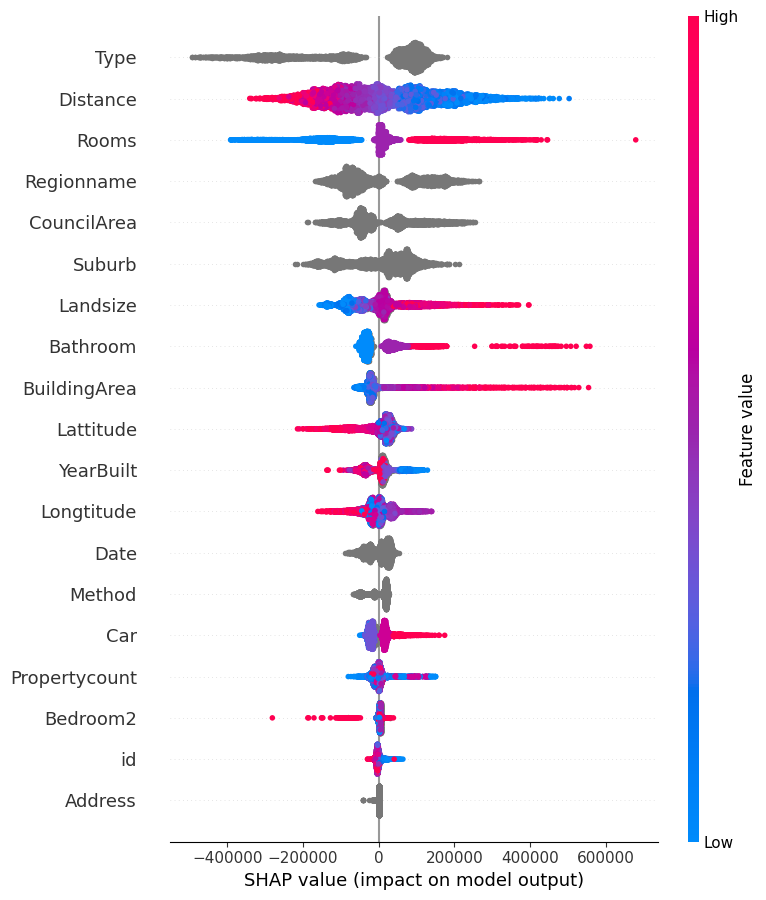

In [247]:
shap.summary_plot(shap_values, test[X]); 

##Submition

In [248]:
test_kaggle.isna().mean()

Suburb           0.000000
Address          0.000000
Rooms            0.000000
Type             0.000000
Method           0.000000
SellerG          0.000000
Date             0.000000
Distance         0.000113
Postcode         0.000113
Bedroom2         0.335677
Bathroom         0.336131
Car              0.366977
Landsize         0.504990
BuildingArea     0.673169
YearBuilt        0.647086
CouncilArea      0.000227
Lattitude        0.330007
Longtitude       0.330007
Regionname       0.000227
Propertycount    0.000227
id               0.000000
dtype: float64

In [249]:
test_kaggle['CouncilArea'] = test_kaggle['CouncilArea'].fillna('no_info')
test_kaggle['Regionname'] = test_kaggle['Regionname'].fillna('no_info')

In [250]:
test_data_pred = Pool(data=test_kaggle[X],
                  cat_features=cat_features
                 )
test_kaggle['Price'] = model.predict(test_data_pred)

In [251]:
test_kaggle[['id', 'Price']].to_csv('predict.csv', index=False)

In [252]:
test_kaggle[['id', 'Price']]

,id,Price
0,30130,8.802457e+05
1,18311,1.328446e+06
2,18934,1.258471e+06
3,1824,8.235018e+05
4,31339,7.625478e+05
...,...,...
8813,11120,1.341339e+06
8814,3950,7.106597e+05
8815,2209,6.672113e+05
8816,23872,1.017278e+06
